# Fine-tuning Whisper on your own data for ASR

This notebook is adapted from [Fine-Tune Whisper For Multilingual ASR with 🤗 Transformers](https://colab.research.google.com/github/sanchit-gandhi/notebooks/blob/main/fine_tune_whisper.ipynb)

## Introduction

Whisper is a pre-trained model for automatic speech recognition (ASR)
published in [September 2022](https://openai.com/blog/whisper/) by the authors
Alec Radford et al. from OpenAI. Unlike many of its predecessors, such as
[Wav2Vec 2.0](https://arxiv.org/abs/2006.11477), which are pre-trained
on un-labelled audio data, Whisper is pre-trained on a vast quantity of
**labelled** audio-transcription data, 680,000 hours to be precise.
This is an order of magnitude more data than the un-labelled audio data used
to train Wav2Vec 2.0 (60,000 hours). What is more, 117,000 hours of this
pre-training data is multilingual ASR data. This results in checkpoints
that can be applied to over 96 languages, many of which are considered
_low-resource_.

When scaled to 680,000 hours of labelled pre-training data, Whisper models
demonstrate a strong ability to generalise to many datasets and domains.
The pre-trained checkpoints achieve competitive results to state-of-the-art
ASR systems, with near 3% word error rate (WER) on the test-clean subset of
LibriSpeech ASR and a new state-of-the-art on TED-LIUM with 4.7% WER (_c.f._
Table 8 of the [Whisper paper](https://cdn.openai.com/papers/whisper.pdf)).
The extensive multilingual ASR knowledge acquired by Whisper during pre-training
can be leveraged for other low-resource languages; through fine-tuning, the
pre-trained checkpoints can be adapted for specific datasets and languages
to further improve upon these results

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/whisper_architecture.svg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 1:</b> Whisper model. The architecture
follows the standard Transformer-based encoder-decoder model. A
log-Mel spectrogram is input to the encoder. The last encoder
hidden states are input to the decoder via cross-attention mechanisms. The
decoder autoregressively predicts text tokens, jointly conditional on the
encoder hidden states and previously predicted tokens. Figure source:
<a href="https://openai.com/blog/whisper/">OpenAI Whisper Blog</a>.</figcaption>
</figure>

The Whisper checkpoints come in five configurations of varying model sizes.
The smallest four are trained on either English-only or multilingual data.
The largest checkpoints are multilingual only. All 11 of the pre-trained checkpoints
are available on the [Hugging Face Hub](https://huggingface.co/models?search=openai/whisper). The
checkpoints are summarised in the following table with links to the models on the Hub:

| Size     | Layers | Width | Heads | Parameters | English-only                                         | Multilingual                                        |
|----------|--------|-------|-------|------------|------------------------------------------------------|-----------------------------------------------------|
| tiny     | 4      | 384   | 6     | 39 M       | [✓](https://huggingface.co/openai/whisper-tiny.en)   | [✓](https://huggingface.co/openai/whisper-tiny.)    |
| base     | 6      | 512   | 8     | 74 M       | [✓](https://huggingface.co/openai/whisper-base.en)   | [✓](https://huggingface.co/openai/whisper-base)     |
| small    | 12     | 768   | 12    | 244 M      | [✓](https://huggingface.co/openai/whisper-small.en)  | [✓](https://huggingface.co/openai/whisper-small)    |
| medium   | 24     | 1024  | 16    | 769 M      | [✓](https://huggingface.co/openai/whisper-medium.en) | [✓](https://huggingface.co/openai/whisper-medium)   |
| large    | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large)    |
| large-v2 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v2) |
| large-v3 | 32     | 1280  | 20    | 1550 M     | x                                                    | [✓](https://huggingface.co/openai/whisper-large-v3) |


For demonstration purposes, we'll fine-tune the multilingual version of the
[`"base"`](https://huggingface.co/openai/whisper-base) checkpoint with 74M params.
As for our data, we'll train and evaluate our system on Vietnamese subset of the
the [Common Voice 17](https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0)
dataset.

## Prepare Environment

First of all, let's try to secure a decent GPU for our Colab! Unfortunately, it's becoming much harder to get access to a good GPU with the free version of Google Colab. However, with Google Colab Pro one should have no issues in being allocated a V100 or P100 GPU.

To get a GPU, click _Runtime_ -> _Change runtime type_, then change _Hardware accelerator_ from _CPU_ to one of the available GPUs, e.g. _T4_ (or better if you have one available). Next, click `Connect T4` in the top right-hand corner of your screen (or `Connect {V100, A100}` if you selected a different GPU).

We can verify that we've been assigned a GPU and view its specifications:

In [ ]:
gpu_info = !nvidia-smi
gpu_info = "\n".join(gpu_info)
if gpu_info.find("failed") >= 0:
    print("Not connected to a GPU")
else:
    print(gpu_info)

Sun Jul 20 03:49:48 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

We'll employ several popular Python packages to fine-tune the Whisper model.
We'll use `datasets[audio]` to download and prepare our training data, alongside
`transformers` and `accelerate` to load and train our Whisper model.
We'll also require the `soundfile` package to pre-process audio files,
`evaluate` and `jiwer` to assess the performance of our model, and
`tensorboard` to log our metrics. Finally, we'll use `gradio` to build a
flashy demo of our fine-tuned model.

In [ ]:
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets[audio]==3.6.0 transformers==4.26.1 accelerate evaluate jiwer tensorboard gradio torchaudio matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 118.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 137.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 148.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 131.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 821.2/821.2 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 393.1/393.1 MB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.7/897.7 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 571.0/571.0 MB 38.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.2/20

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
MODEL_NAME = "openai/whisper-base"
DATASET_PATH = "mozilla-foundation/common_voice_17_0"

## Load Dataset

Using 🤗 Datasets, downloading and preparing data is extremely simple.
We can download and prepare the Common Voice splits in just one line of code.

First, ensure you have accepted the terms of use on the Hugging Face Hub: [mozilla-foundation/common_voice_17_0](https://huggingface.co/datasets/mozilla-foundation/common_voice_17_0). Once you have accepted the terms, you will have full access to the dataset and be able to download the data locally.

In [3]:
from datasets import DatasetDict, load_dataset

common_voice = DatasetDict()

common_voice["train"] = load_dataset(
    DATASET_PATH,
    "vi",
    split="train+validation",
)
common_voice["test"] = load_dataset(
    DATASET_PATH,
    "vi",
    split="test",
)
print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 2939
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment', 'variant'],
        num_rows: 1274
    })
})


Most ASR datasets only provide input audio samples (`audio`) and the
corresponding transcribed text (`sentence`). Common Voice contains additional
metadata information, such as `accent` and `locale`, which we can disregard for ASR.
Keeping the notebook as general as possible, we only consider the input audio and
transcribed text for fine-tuning, discarding the additional metadata information:

In [4]:
common_voice = common_voice.remove_columns(
    [
        "accent",
        "age",
        "client_id",
        "down_votes",
        "gender",
        "locale",
        "path",
        "segment",
        "up_votes",
        "variant",
    ]
)
print(common_voice)

DatasetDict({
    train: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 2939
    })
    test: Dataset({
        features: ['audio', 'sentence'],
        num_rows: 1274
    })
})


## Prepare Feature Extractor, Tokenizer and Data

The ASR pipeline can be de-composed into three stages:

1. A feature extractor which pre-processes the raw audio-inputs
2. The model which performs the sequence-to-sequence mapping
3. A tokenizer which post-processes the model outputs to text format

In 🤗 Transformers, the Whisper model has an associated feature extractor and tokenizer,
called [WhisperFeatureExtractor](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperFeatureExtractor)
and [WhisperTokenizer](https://huggingface.co/docs/transformers/main/model_doc/whisper#transformers.WhisperTokenizer)
respectively.

We'll go through details for setting-up the feature extractor and tokenizer one-by-one!

### Load WhisperFeatureExtractor

The Whisper feature extractor performs two operations:
1. Pads / truncates the audio inputs to 30s: any audio inputs shorter than 30s are padded to 30s with silence (zeros), and those longer that 30s are truncated to 30s
2. Converts the audio inputs to _log-Mel spectrogram_ input features, a visual representation of the audio and the form of the input expected by the Whisper model

<figure>
<img src="https://raw.githubusercontent.com/sanchit-gandhi/notebooks/main/spectrogram.jpg" alt="Trulli" style="width:100%">
<figcaption align = "center"><b>Figure 2:</b> Conversion of sampled audio array to log-Mel spectrogram.
Left: sampled 1-dimensional audio signal. Right: corresponding log-Mel spectrogram. Figure source:
<a href="https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html">Google SpecAugment Blog</a>.
</figcaption>

We'll load the feature extractor from the pre-trained checkpoint with the default values:

In [5]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(
    MODEL_NAME, cache_dir="./cache"
)

/home/azureuser/test/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Load WhisperTokenizer

The Whisper model outputs a sequence of _token ids_. The tokenizer maps each of these token ids to their corresponding text string. For Hindi, we can load the pre-trained tokenizer and use it for fine-tuning without any further modifications. We simply have to
specify the target language and the task. These arguments inform the
tokenizer to prefix the language and task tokens to the start of encoded
label sequences:

In [6]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(
    MODEL_NAME, language="vietnamese", task="transcribe", cache_dir="./cache"
)

### Combine To Create A WhisperProcessor

To simplify using the feature extractor and tokenizer, we can _wrap_
both into a single `WhisperProcessor` class. This processor object
inherits from the `WhisperFeatureExtractor` and `WhisperProcessor`,
and can be used on the audio inputs and model predictions as required.
In doing so, we only need to keep track of two objects during training:
the `processor` and the `model`:

In [7]:
from transformers import WhisperProcessor

processor = WhisperProcessor(feature_extractor=feature_extractor, tokenizer=tokenizer)

### Prepare Data

Let's print the first example of the Common Voice dataset to see
what form the data is in:

In [8]:
print(common_voice["train"][0])

{'audio': {'path': '/home/azureuser/.cache/huggingface/datasets/downloads/extracted/0341a6c8abe81f0a138b87dcf379d3dcd4994c8326a00a95e9e8f65ffcdc88aa/vi_train_0/common_voice_vi_23901117.mp3', 'array': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.90132641e-06, 7.18296724e-06, 1.22913943e-05], shape=(286848,)), 'sampling_rate': 48000}, 'sentence': 'quả nhiên trúng tuyển vào trường Quốc Lập'}


Since
our input audio is sampled at 48kHz, we need to _downsample_ it to
16kHz prior to passing it to the Whisper feature extractor, 16kHz being the sampling rate expected by the Whisper model.

We'll set the audio inputs to the correct sampling rate using dataset's
[`cast_column`](https://huggingface.co/docs/datasets/package_reference/main_classes.html?highlight=cast_column#datasets.DatasetDict.cast_column)
method. This operation does not change the audio in-place,
but rather signals to `datasets` to resample audio samples _on the fly_ the
first time that they are loaded:

In [9]:
from datasets import Audio

common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

Re-loading the first audio sample in the Common Voice dataset will resample
it to the desired sampling rate:

In [10]:
print(common_voice["train"][0])

{'audio': {'path': '/home/azureuser/.cache/huggingface/datasets/downloads/extracted/0341a6c8abe81f0a138b87dcf379d3dcd4994c8326a00a95e9e8f65ffcdc88aa/vi_train_0/common_voice_vi_23901117.mp3', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -1.79643739e-05, -1.54107620e-05,  3.32880700e-06], shape=(95616,)), 'sampling_rate': 16000}, 'sentence': 'quả nhiên trúng tuyển vào trường Quốc Lập'}


Now we can write a function to prepare our data ready for the model:
1. We load and resample the audio data by calling `batch["audio"]`. As explained above, 🤗 Datasets performs any necessary resampling operations on the fly.
2. We filter out audio samples that are too short (<1s) or too long (>30s)
3. We use the feature extractor to compute the log-Mel spectrogram input features from our 1-dimensional audio array.
4. We encode the transcriptions to label ids through the use of the tokenizer.

In [11]:
def filter_audio_length(example):
    """Filter out audio samples that are too short (<1s) or too long (>30s)"""
    audio_array = example["audio"]["array"]
    sampling_rate = example["audio"]["sampling_rate"]
    duration = len(audio_array) / sampling_rate

    # Keep only audio between 1 and 30 seconds
    return 1.0 <= duration <= 30.0

In [12]:
common_voice = common_voice.filter(filter_audio_length)

For concept only, we'll use 1,000 samples from the training set and 500 from the test set.

In [13]:
common_voice["train"] = common_voice["train"].shuffle(seed=42).select(range(1000))
common_voice["test"] = common_voice["test"].shuffle(seed=42).select(range(500))

So we have 1.19 hours of audio for training and 0.53 hours for testing.

In [14]:
def calculate_audio_hours(dataset_dict):
    """Calculate total audio hours for each split in the dataset."""
    print("Dataset statistics:")
    for split_name, dataset in dataset_dict.items():
        if "audio" in dataset.column_names:
            # For original dataset with audio column
            total_duration = sum(
                len(audio["array"]) / audio["sampling_rate"]
                for audio in dataset["audio"]
            )
        hours = total_duration / 3600
        print(
            f"{split_name.upper()} set: {len(dataset):,} samples, {hours:.2f} hours of audio"
        )


calculate_audio_hours(common_voice)

Dataset statistics:


TRAIN set: 1,000 samples, 1.19 hours of audio
TEST set: 500 samples, 0.53 hours of audio


In [15]:
def prepare_dataset(batch):
    # load and resample audio data from 48 to 16kHz
    audio = batch["audio"]

    # compute log-Mel input features from input audio array
    batch["input_features"] = feature_extractor(
        audio["array"], sampling_rate=audio["sampling_rate"]
    ).input_features[0]

    # encode target text to label ids
    batch["labels"] = tokenizer(batch["sentence"]).input_ids
    return batch

In [16]:
prepared_dataset = common_voice.map(
    prepare_dataset,
    remove_columns=common_voice.column_names["train"],
    num_proc=5,
)

### Inputs/Outputs Visualization

[50258, 50278, 50359, 50363, 44, 656, 32432, 20136, 272, 22476, 417, 9667, 50257]
<|startoftranscript|><|vi|><|transcribe|><|notimestamps|>Mang mang những bàn chân<|endoftext|>


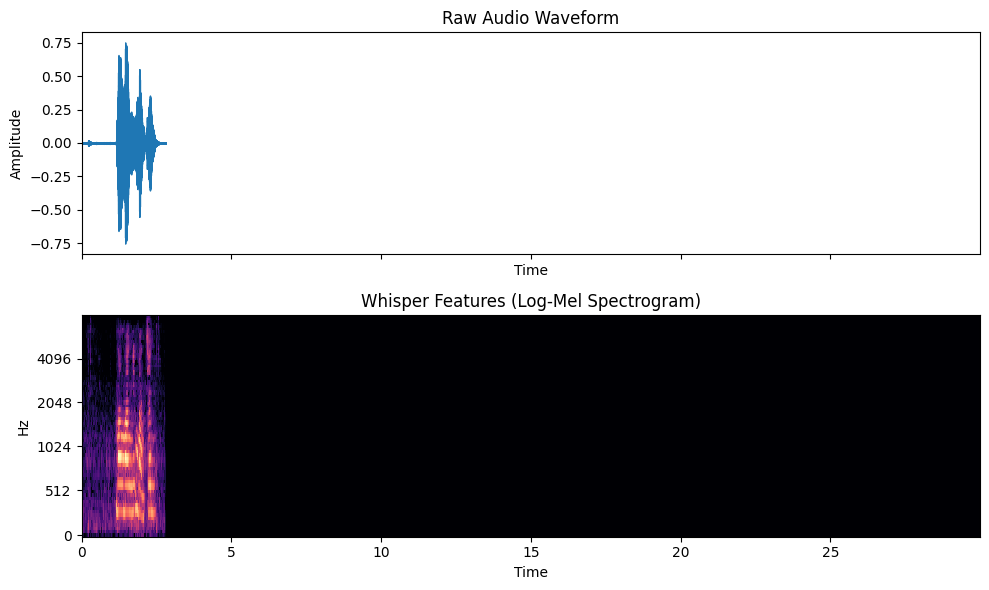

In [21]:
import matplotlib.pyplot as plt
from librosa.display import specshow, waveshow
import numpy as np
from IPython import display

tokens = prepared_dataset["train"][0]["labels"]
sentence = tokenizer.decode(tokens)
features = np.array(prepared_dataset["train"][0]["input_features"])
audio = np.array(common_voice["train"][0]["audio"]["array"])
sr = common_voice["train"][0]["audio"]["sampling_rate"]

print(tokens)
print(sentence)
display.display(
    display.Audio(
        audio,
        rate=sr,
    )
)

fig, axs = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

waveshow(audio, sr=sr, ax=axs[0])
axs[0].set_title("Raw Audio Waveform")
axs[0].set_ylabel("Amplitude")

specshow(
    features,
    sr=sr,
    hop_length=160,
    x_axis="time",
    y_axis="mel",
    cmap="magma",
    ax=axs[1],
)
axs[1].set_title("Whisper Features (Log-Mel Spectrogram)")

plt.tight_layout()
plt.show()

## Training and Evaluation

Now that we've prepared our data, we're ready to dive into the training pipeline.
The [🤗 Trainer](https://huggingface.co/transformers/master/main_classes/trainer.html?highlight=trainer)
will do much of the heavy lifting for us. All we have to do is:

- Load a pre-trained checkpoint: we need to load a pre-trained checkpoint and configure it correctly for training.

- Define a data collator: the data collator takes our pre-processed data and prepares PyTorch tensors ready for the model.

- Evaluation metrics: during evaluation, we want to evaluate the model using the [word error rate (WER)](https://huggingface.co/metrics/wer) metric. We need to define a `compute_metrics` function that handles this computation.

- Define the training configuration: this will be used by the 🤗 Trainer to define the training schedule.

Once we've fine-tuned the model, we will evaluate it on the test data to verify that we have correctly trained it
to transcribe speech in Hindi.

### Load a Pre-Trained Checkpoint

We'll start our fine-tuning run from the pre-trained Whisper `base` checkpoint,
the weights for which we need to load from the Hugging Face Hub. Again, this
is trivial through use of 🤗 Transformers!

In [22]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(MODEL_NAME, cache_dir="./cache")
# Disable cache for gradient checkpointing compatibility
model.config.use_cache = False

/home/azureuser/test/.venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


### Define a Data Collator

The data collator for a sequence-to-sequence speech model is unique in the sense that it
treats the `input_features` and `labels` independently: the  `input_features` must be
handled by the feature extractor and the `labels` by the tokenizer.

The `input_features` are already padded to 30s and converted to a log-Mel spectrogram
of fixed dimension by action of the feature extractor, so all we have to do is convert the `input_features`
to batched PyTorch tensors. We do this using the feature extractor's `.pad` method with `return_tensors=pt`.

The `labels` on the other hand are un-padded. We first pad the sequences
to the maximum length in the batch using the tokenizer's `.pad` method. The padding tokens
are then replaced by `-100` so that these tokens are **not** taken into account when
computing the loss. We then cut the BOS token from the start of the label sequence as we
append it later during training.

We can leverage the `WhisperProcessor` we defined earlier to perform both the
feature extractor and the tokenizer operations:

In [23]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(
        self, features: List[Dict[str, Union[List[int], torch.Tensor]]]
    ) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [
            {"input_features": feature["input_features"]} for feature in features
        ]
        batch = self.processor.feature_extractor.pad(
            input_features, return_tensors="pt"
        )

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(
            labels_batch.attention_mask.ne(1), -100
        )

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

Let's initialise the data collator we've just defined:

In [25]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(
    processor=processor,
    decoder_start_token_id=model.config.decoder_start_token_id,
)
print(tokenizer.decode(model.config.decoder_start_token_id))

<|startoftranscript|>


### Evaluation Metrics

We'll use the word error rate (WER) metric, the 'de-facto' metric for assessing
ASR systems. For more information, refer to the WER [docs](https://huggingface.co/metrics/wer). We'll load the WER metric from 🤗 Evaluate:

In [ ]:
import evaluate

metric = evaluate.load("wer")

We then simply have to define a function that takes our model
predictions and returns the WER metric. This function, called
`compute_metrics`, first replaces `-100` with the `pad_token_id`
in the `label_ids` (undoing the step we applied in the
data collator to ignore padded tokens correctly in the loss).
It then decodes the predicted and label ids to strings. Finally,
it computes the WER between the predictions and reference labels:

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Define the Training Configuration

In the final step, we define all the parameters related to training. For more detail on the training arguments, refer to the Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

In [ ]:
from transformers import Seq2SeqTrainingArguments

output_dir = f"./{MODEL_NAME.replace('/', '_')}-vi"

training_args = Seq2SeqTrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,
    learning_rate=1e-5,
    warmup_steps=300,
    max_steps=1000,
    gradient_checkpointing=True,
    # bf16=True,
    fp16=True,
    evaluation_strategy="steps",
    per_device_eval_batch_size=16,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=200,
    eval_steps=100,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=False,
)

PyTorch: setting up devices


**Note**: if one does not want to upload the model checkpoints to the Hub,
set `push_to_hub=False`.

We can forward the training arguments to the 🤗 Trainer along with our model,
dataset, data collator and `compute_metrics` function:

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=prepared_dataset["train"],
    eval_dataset=prepared_dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
)

max_steps is given, it will override any value given in num_train_epochs
Using cuda_amp half precision backend
/usr/local/lib/python3.11/dist-packages/transformers/trainer.py:593: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


We'll save the processor object once before starting training. Since the processor is not trainable, it won't change over the course of training:

In [ ]:
processor.save_pretrained(training_args.output_dir)

Feature extractor saved in ./openai_whisper-base-vi/preprocessor_config.json
tokenizer config file saved in ./openai_whisper-base-vi/tokenizer_config.json
Special tokens file saved in ./openai_whisper-base-vi/special_tokens_map.json
added tokens file saved in ./openai_whisper-base-vi/added_tokens.json


### Training

To launch training, simply execute:

In [ ]:
def evaluate_model(trainer, dataset_name="test"):
    """Evaluate the model and return metrics."""
    print(f"\n=== Evaluating on {dataset_name} set ===")
    eval_results = trainer.evaluate()
    wer = eval_results.get("eval_wer", 0)
    print(f"WER: {wer:.2f}%")
    return eval_results

In [ ]:
# Evaluate before training
print("Evaluating model BEFORE training...")
initial_metrics = evaluate_model(trainer, "test")

# Train the model
print("Starting training...")
trainer.train()

# Evaluate after training
print("Evaluating model AFTER training...")
final_metrics = evaluate_model(trainer, "test")

### Results:
| Metric        | Value                                   |
|---------------|-----------------------------------------|
| Initial WER   | 62.97%                                  |
| Final WER     | 40.23%                                  |
| Improvement   | 22.74 percentage points (36.1% relative improvement) |

## Comparison Demo

Running the example below will generate a Gradio demo where we
can record speech through the microphone of our computer and input it to
our fine-tuned Whisper model and the original Whisper base model to transcribe the corresponding text:

In [ ]:
from transformers import pipeline, AutoModelForSpeechSeq2Seq, AutoProcessor
import gradio as gr
import numpy as np
import soundfile as sf

output_dir = f"./{MODEL_NAME.replace('/', '_')}-vi"

# Define two pipelines for two different models
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    f"{output_dir}/checkpoint-400",
    low_cpu_mem_usage=True,
)
processor = AutoProcessor.from_pretrained(output_dir)
pipe1 = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
)

pipe2 = pipeline(
    "automatic-speech-recognition",
    model="openai/whisper-base",
    framework="pt",  # Explicitly set framework to PyTorch
)


def transcribe_both(audio_filepath):
    # If no audio is provided, return empty strings
    if audio_filepath is None:
        return "", ""
    # Read the audio file as numpy array
    try:
        audio, sr = sf.read(audio_filepath)
        # If stereo, convert to mono
        if len(audio.shape) > 1:
            audio = np.mean(audio, axis=1)
    except Exception as e:
        return f"Error reading audio: {e}", f"Error reading audio: {e}"

    input_dict = {"array": audio, "sampling_rate": sr}
    # Transcribe with both models
    try:
        text1 = pipe1(input_dict.copy())["text"]
    except Exception as e:
        text1 = f"Error: {e}"
    try:
        text2 = pipe2(input_dict.copy())["text"]
    except Exception as e:
        text2 = f"Error: {e}"
    return text1, text2


iface = gr.Interface(
    fn=transcribe_both,
    inputs=gr.Audio(
        sources=["microphone", "upload"], type="filepath", show_download_button=True
    ),
    outputs=[
        gr.Textbox(label="Fine-tuned Whisper (Vietnamese)"),
        gr.Textbox(label="Original Whisper Base"),
    ],
    title="Whisper Base Vietnamese - Model Comparison",
    description="Compare transcriptions from a fine-tuned Whisper base model and the original Whisper base model. Record or upload audio to see both outputs.",
)

iface.launch()

In [29]:
iface.close()

Closing server running on port: 7860
